<a href="https://colab.research.google.com/github/AlexeyK12/AI-ARROW---Autumn_2024/blob/main/%22%D0%94%D0%97_1_AI_ARROW_4_tasks_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Осенний буткемп "AI ARROW"

## Домашнее задание
Все задания рекомендуем выполнять на GPU в Colab.

### Задание 1 - Классификация MNIST c помощью Pytorch (5 баллов)

In [ ]:
# Импортируем необходимые библиотеки

from IPython.display import clear_output, display
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from tqdm.auto import trange

import torch.nn as nn
import torch.optim as optim

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

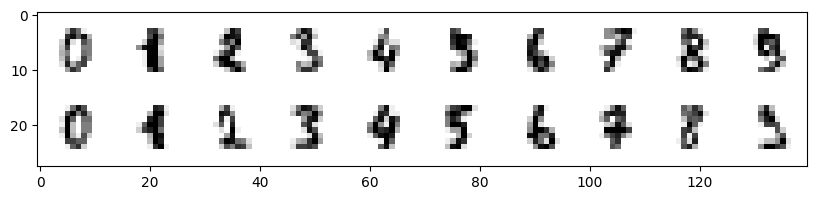

In [ ]:
# Загрузка датасета MNIST
images, targets = load_digits(return_X_y=True)

# Отображение классов и изображений
grid = np.pad(images[:20].reshape(20, 8, 8), [[0, 0], [3, 3], [3, 3]]).reshape(2, 10, 14, 14).swapaxes(1, 2).reshape(28, -1)
plt.figure(figsize=(10, 2))
plt.imshow(grid, cmap='gray_r')
targets[:20].reshape(2, 10)

In [ ]:
# Разделение на train и test
images_train, images_test, targets_train, targets_test = train_test_split(images, targets, test_size=0.2, random_state=12)

# Создаем torch tensor из np.array
images_train = torch.tensor(images_train, dtype=torch.float32)
images_test = torch.tensor(images_test, dtype=torch.float32)
targets_train = torch.tensor(targets_train, dtype=torch.long)
targets_test = torch.tensor(targets_test, dtype=torch.long)

#### Отладка без обучения нс.

In [ ]:
hidden_dim_size = 80
input_size = 8 * 8
number_of_classes = 10

# Определяем полносвязную нейронную сеть с двумя Linear слоями и функцией активации ReLU между ними
net = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_dim_size, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_dim_size, number_of_classes, bias=True)
)

In [ ]:
# Первый прогон данных через необученную нс.
net_outputs = net(images_train[:2])
net_outputs

tensor([[ 0.7498, -1.0266,  2.5627, -0.5394,  0.7466,  1.2671,  0.3571, -0.4518,
          0.1193, -0.0937],
        [ 0.9891, -1.2550,  2.8089,  0.2349, -1.5856,  2.0303, -1.1245, -0.6429,
         -0.3540, -0.3874]], grad_fn=<AddmmBackward0>)

In [ ]:
print(torch.all((0 <= net_outputs) & (net_outputs <= 1)))
print(net_outputs.sum(dim=-1))

tensor(False)
tensor([3.6910, 0.7139], grad_fn=<SumBackward1>)


In [ ]:
# Применение Softmax на выходе нс. для получения вероятностей
softmax = torch.nn.Softmax(dim=-1)
probabilities = softmax(net_outputs)

print(torch.all((0 <= probabilities) & (probabilities <= 1)))
print(probabilities.sum(dim=-1))

tensor(True)
tensor([1.0000, 1.0000], grad_fn=<SumBackward1>)


In [ ]:
# Определение позиции элемента с максимальных значением вероятности
max_probabilies, ids_of_max_probabilities = probabilities.max(dim=-1)
ids_of_max_probabilities

tensor([2, 2])

In [ ]:
# Определение и применение функции потерь CrossEntropyLoss из библиотеки torch
loss_function =  torch.nn.CrossEntropyLoss()
loss_function(net_outputs, targets_train[:2])

tensor(3.0280, grad_fn=<NllLossBackward0>)

#### Обучение нс.

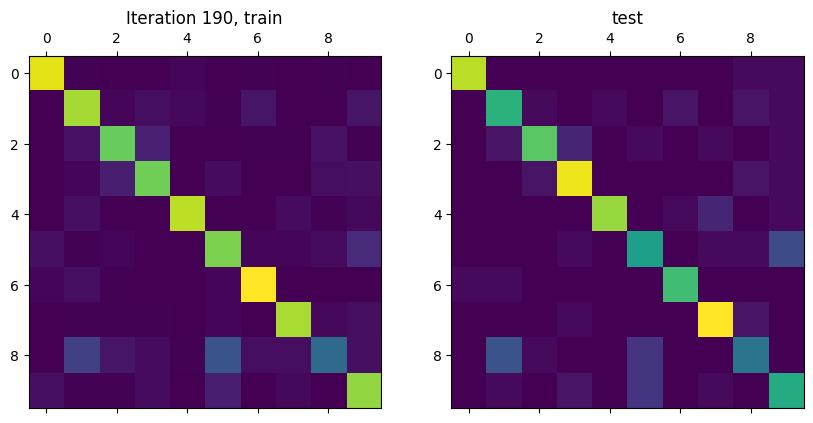

In [ ]:
hidden_dim_size = 80
input_size = 8 * 8
number_of_classes = 10

# Определяем полносвязную нейронную сеть с двумя Linear слоями и функцией активации ReLU между ними
net = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_dim_size, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_dim_size, number_of_classes, bias=True)
)

# Применить оптимизатор SGD из torch, установить learning rate равный 1e-3
optimizer = optim.SGD(net.parameters(), lr=1e-3)

# Определение функции потерь
loss_function = nn.CrossEntropyLoss()

# Для визуализации обучения
fig, [ax_train, ax_test] = plt.subplots(1, 2, figsize=[10, 5])

# Визуализация матрицы ошибок
def visualize():
    ax_train.clear()
    ax_train.set_title(f'Iteration {iter_i}, train')
    ax_train.matshow(confusion_matrix(targets_train, get_predicted_classes(images_train)))
    ax_test.set_title(f'test')
    ax_test.matshow(confusion_matrix(targets_test, get_predicted_classes(images_test)))
    clear_output(wait=True)
    display(fig)

def get_predicted_classes(images):
    return softmax(net(images).detach()).max(dim=-1)[1]

iters_n = 200

# Цикл обучения
for iter_i in range(iters_n):

    # Передаем данные в нс. получаем ответы
    nn_outputs = net(images_train)

    # Считаем ошибку итерации обучения
    loss = loss_function(nn_outputs, targets_train)

    # Обнуляем градиенты
    optimizer.zero_grad()

    # Считаем градиенты и делаем обратное распространение ошибки
    loss.backward()

    # Делаем шаг оптимизатора
    optimizer.step()

    # Отрисовка матрицы ошибок каждые 10 эпох
    if iter_i % 10 == 0:
        visualize()
plt.close()

### Задание 2 - Классификация котов и собак (15 баллов)

In [ ]:
# Загрузим и распакуем датасет
!wget -nc https://www.dropbox.com/s/gqdo90vhli893e0/data.zip
!unzip -n data.zip -d data

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/train_11k/dog/dog.11174.jpg  
  inflating: data/train_11k/dog/dog.11175.jpg  
  inflating: data/train_11k/dog/dog.11177.jpg  
  inflating: data/train_11k/dog/dog.11180.jpg  
  inflating: data/train_11k/dog/dog.11182.jpg  
  inflating: data/train_11k/dog/dog.11183.jpg  
  inflating: data/train_11k/dog/dog.11185.jpg  
  inflating: data/train_11k/dog/dog.11189.jpg  
  inflating: data/train_11k/dog/dog.1119.jpg  
  inflating: data/train_11k/dog/dog.11190.jpg  
  inflating: data/train_11k/dog/dog.11193.jpg  
  inflating: data/train_11k/dog/dog.11194.jpg  
  inflating: data/train_11k/dog/dog.11196.jpg  
  inflating: data/train_11k/dog/dog.11197.jpg  
  inflating: data/train_11k/dog/dog.11198.jpg  
  inflating: data/train_11k/dog/dog.1120.jpg  
  inflating: data/train_11k/dog/dog.11201.jpg  
  inflating: data/train_11k/dog/dog.11202.jpg  
  inflating: data/train_11k/dog/dog.11204.jpg  
  inflating: data/trai

In [ ]:
# Импортируем необходимые библиотеки

import os
from matplotlib import pyplot as plt
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchsummary import summary

In [ ]:
# Зафиксируем random seed для воспроизводимости результатов
torch.manual_seed(22)

In [ ]:
# Определим в одном месте все константы, которые понадобятся нам в дальнейшем.
# Их смысл будет прояснён по мере использования

# Путь до датасета
DATA_PATH = 'data'

# Количество потоков для data loader
NUM_WORKERS = 4

# Размер изображения и кол-во каналов
SIZE_H = SIZE_W = 96
N_CHANNELS = 3

# Число классов в датасете
NUM_CLASSES = 2

# Количество эпох
EPOCH_NUM = 30

# Размер батча, обычно является 2**N
BATCH_SIZE = 128

# Среднее и среднеквадратичное для нормализации изображения
image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

# Размер последнего слоя (embeddings) CNN модели
EMBEDDING_SIZE = 256

In [ ]:
# Просмотр парамертов GPU.
# Для запуска Colab на GPU: Среда выполнения -> Сменить среду выполнения -> T4 GPU
!nvidia-smi

Sat Oct 19 12:51:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Если GPU активировано, то выполнение команды выдаст такое сообщение

```
Mon Oct 14 20:24:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   GI   CI        PID   Type   Process name                            GPU Memory |
|        ID   ID                                                             Usage      |
|=======================================================================================|
|  No running processes found                                                           |
+---------------------------------------------------------------------------------------+
```



In [ ]:
# Используем GPU при наличии
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
transformer = transforms.Compose([
    transforms.Resize((SIZE_H, SIZE_W)),        # Масштабирование изображений до фиксированного размера
    transforms.ToTensor(),                      # Преобразование в тензор
    transforms.Normalize(image_mean, image_std) # Нормализация изображения для каждого канала
])

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'train_11k'), transform=transformer)
val_dataset   = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'val'), transform=transformer)
test_dataset  = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'test_labeled'), transform=transformer)

In [ ]:
n_train, n_val, n_test = len(train_dataset), len(val_dataset), len(test_dataset)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### Задание 2.1. Изучить содержимое train_loader (1 балл)
Провести исследование данных, на которых обучаемся. Отобразить картинки из батча и вывести их метки

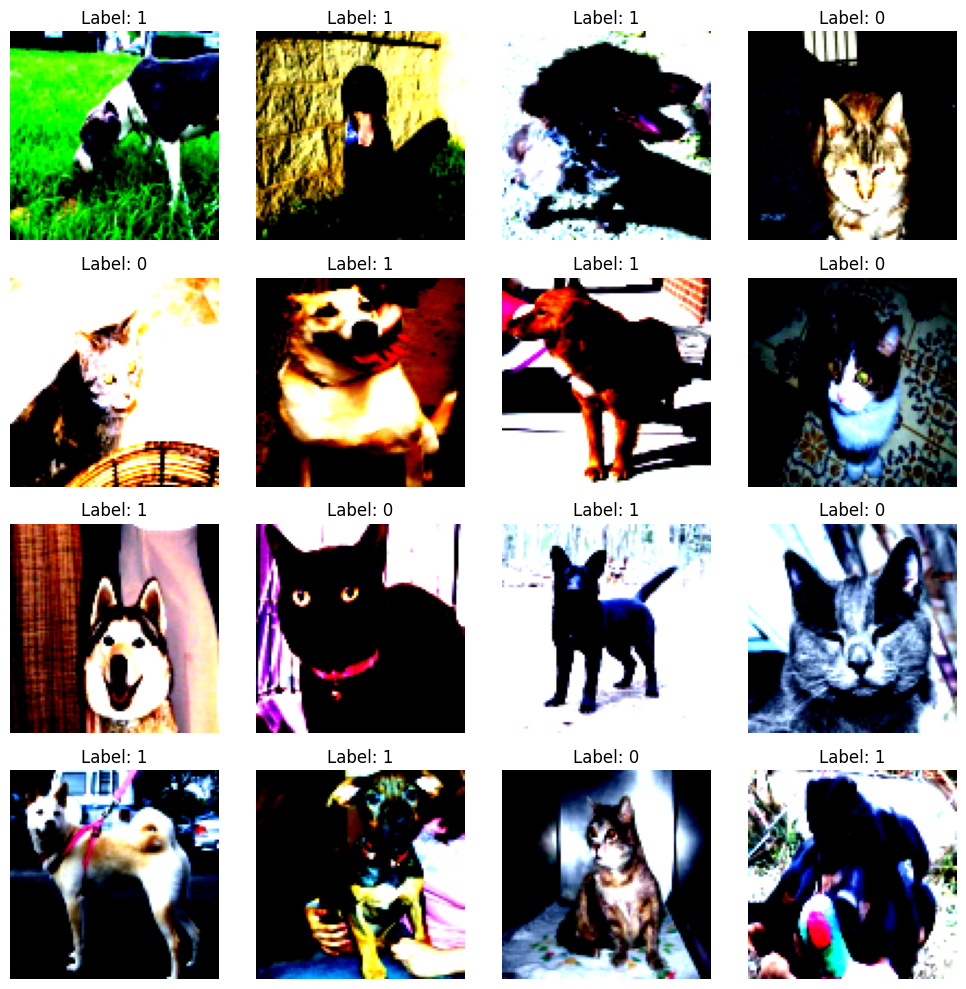

In [ ]:
train_iterator = iter(train_loader)
images_batch, images_labels = next(train_iterator)

num_images = 16

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for img, label, ax in zip(images_batch[:num_images], images_labels[:num_images], axes):
    if img.shape[0] == 3:
        img = img.permute(1, 2, 0)
    else:
        img = img.squeeze()

    ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
    ax.set_title(f'Label: {label.item()}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs):

    '''
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''

    train_loss = []
    val_accuracy = []

    for epoch in range(n_epochs):
        start_time = time.time()

        model.train(True)
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            opt.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            opt.step()
            train_loss.append(loss.item())

        model.train(False)
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss_value = np.mean(train_loss[-n_train // BATCH_SIZE :])
        val_accuracy_value = np.mean(val_accuracy[-n_val // BATCH_SIZE :]) * 100

        print(f"  training loss (in-iteration): \t{train_loss_value:.6f}")
        print(f"  validation accuracy: \t\t\t{val_accuracy_value:.2f} %")

    return model, train_loss, val_accuracy

In [ ]:
def test_model(model, test_loader, subset='test'):
    model.train(False)
    test_batch_acc = []
    for X_batch, y_batch in test_loader:
        logits = model(X_batch.to(device))
        y_pred = logits.max(1)[1].data
        test_batch_acc.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    test_accuracy = np.mean(test_batch_acc)

    print("Results:")
    print(f"  {subset} accuracy:\t\t{test_accuracy * 100:.2f} %")
    if test_accuracy > 0.9:
        print("Amazing!")
    elif test_accuracy > 0.7:
        print("Good!")
    else:
        print("We need more magic! Follow instructons below")
    return test_accuracy

#### Задание 2.2. Реализовать сверточную нейросеть для задачи классификации (4 балла)

**conv-pool-conv-pool-dense-dense!**

Создайте мини-сверточную нейронную сеть со следующей структурой:
* Входной слой
* 3 классических сверточных блока`convolution->relu->pool`:
  * свертка 3x3 с 128 фильтрами и функцией активации _ReLU_
  * 2x2 пулинг (или поставьте для предыдущей свертки страйд = 3)
 * Flatten
* 30% Dropout
* Линейный слой с 256 нейронами и функцией активации _ReLU_
* 30% dropout
* Выходной линейный слой.

__Convolutional layers__ в торче создаются как любой другой слой, но у него есть особые параметры:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3)) # светрка`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2 на 2`__

__`...`__


Когда вы закончите создание нейросети (когда функция compute_loss не будет поднимать ошибки), обучите её с оптимайзером __Adam__ с шагом обучения LR = 3e-4 (learning rate)

Если всё верно, вы должны получить минимум __75%__ точности на валидации.

__Подсказка 1__ : количество каналов должно быть в порядке количества class_labels

__Подсказка 2__ : вы можете поставить stride=2 для Conv2d слоя чтобы увеличить скорость обучения, но помните про размерности

__Подсказка 3__ : можно не считать размерности слоев руками, просто вставьте любую размерность и запуститите (например, 1 юнит) и  запустите compute_loss. Вы получите ошибку:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__
Видите __1960__? Это та размерность, которую вам нужно выставить.

In [ ]:
model_cnn = nn.Sequential()

model_cnn.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1, padding=1))
model_cnn.add_module('relu1', nn.ReLU())
model_cnn.add_module('pool1', nn.MaxPool2d(kernel_size=2, stride=2))

model_cnn.add_module('conv2', nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1))
model_cnn.add_module('relu2', nn.ReLU())
model_cnn.add_module('pool2', nn.MaxPool2d(kernel_size=2, stride=2))

model_cnn.add_module('conv3', nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1))
model_cnn.add_module('relu3', nn.ReLU())
model_cnn.add_module('pool3', nn.MaxPool2d(kernel_size=2, stride=2))

model_cnn.add_module('gap_5', nn.AdaptiveAvgPool2d((1, 1)))
model_cnn.add_module('dropout_5', nn.Dropout(0.3))

model_cnn.add_module('flat', nn.Flatten())

model_cnn.add_module('fc_6', nn.Linear(128, EMBEDDING_SIZE))
model_cnn.add_module('relu_6', nn.ReLU())
model_cnn.add_module('dropout_6', nn.Dropout(0.3))

model_cnn.add_module('fc_logits', nn.Linear(EMBEDDING_SIZE, NUM_CLASSES))
model_cnn.add_module('fc_preds', nn.Sigmoid())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cnn.to(device)

Sequential(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap_5): AdaptiveAvgPool2d(output_size=(1, 1))
  (dropout_5): Dropout(p=0.3, inplace=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc_6): Linear(in_features=128, out_features=256, bias=True)
  (relu_6): ReLU()
  (dropout_6): Dropout(p=0.3, inplace=False)
  (fc_logits): Linear(in_features=256, out_features=2, bias=True)
  (fc_preds): Sigmoid()
)

In [ ]:
summary(model_cnn, train_dataset[0][0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 96, 96]           3,584
              ReLU-2          [-1, 128, 96, 96]               0
         MaxPool2d-3          [-1, 128, 48, 48]               0
            Conv2d-4          [-1, 128, 48, 48]         147,584
              ReLU-5          [-1, 128, 48, 48]               0
         MaxPool2d-6          [-1, 128, 24, 24]               0
            Conv2d-7          [-1, 128, 24, 24]         147,584
              ReLU-8          [-1, 128, 24, 24]               0
         MaxPool2d-9          [-1, 128, 12, 12]               0
AdaptiveAvgPool2d-10            [-1, 128, 1, 1]               0
          Dropout-11            [-1, 128, 1, 1]               0
          Flatten-12                  [-1, 128]               0
           Linear-13                  [-1, 256]          33,024
             ReLU-14                  [

In [ ]:
# Оптимайзер
opt = optim.Adam(model_cnn.parameters(), lr=3e-4)

# Функция потерь (Лосс функция)
loss_fn = nn.CrossEntropyLoss()

# Число эпох
n_epochs = 50

In [ ]:
%%time
opt.zero_grad()
model_cnn, train_loss, val_accuracy = train_model(model_cnn, train_loader, val_loader, loss_fn, opt, n_epochs)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1 of 50 took 37.308s
  training loss (in-iteration): 	0.664738
  validation accuracy: 			58.33 %
Epoch 2 of 50 took 38.370s
  training loss (in-iteration): 	0.641365
  validation accuracy: 			60.95 %
Epoch 3 of 50 took 38.559s
  training loss (in-iteration): 	0.628986
  validation accuracy: 			60.94 %
Epoch 4 of 50 took 38.742s
  training loss (in-iteration): 	0.618565
  validation accuracy: 			60.57 %
Epoch 5 of 50 took 39.329s
  training loss (in-iteration): 	0.607895
  validation accuracy: 			64.32 %
Epoch 6 of 50 took 39.683s
  training loss (in-iteration): 	0.597661
  validation accuracy: 			65.08 %
Epoch 7 of 50 took 40.129s
  training loss (in-iteration): 	0.587315
  validation accuracy: 			62.43 %
Epoch 8 of 50 took 38.226s
  training loss (in-iteration): 	0.571497
  validation accuracy: 			66.11 %
Epoch 9 of 50 took 38.212s
  training loss (in-iteration): 	0.557620
  validation accuracy: 			67.73 %
Epoch 10 of 50 took 38.372s
  training loss (in-iteration): 	0.559647
  v

In [ ]:
best_model_cnn = model_cnn

val_accuracy = test_model(best_model_cnn, val_loader, subset='val')
test_accuracy = test_model(best_model_cnn, test_loader, subset='test')

Results:
  val accuracy:		77.83 %
Good!
Results:
  test accuracy:		80.29 %
Good!


### Задание 3 - Знакомство с Roboflow и YOLOv11 (5 баллов)

Зарегистрируйтесь на https://public.roboflow.com/. Изучите возможности сервиса. Попробуйте самостоятельно создать, разметить и экспортировать собственный датасет. Загрузите в Colab датасет - https://universe.roboflow.com/tiger-vliot/tiger-z0d6k

**Подсказка**: см. раздел Dataset

Необходимо будет в ячейке запустить подобную команду:
```
!curl -L "https://universe.roboflow.com/ds/lwP1Jek5kM?key=<ваш ключ>" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
```



In [ ]:
!curl -L "https://app.roboflow.com/ds/lRx42Ym9JZ?key=dlhRg46dpX" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   900  100   900    0     0   3219      0 --:--:-- --:--:-- --:--:--  3214
100 32.2M  100 32.2M    0     0  11.3M      0  0:00:02  0:00:02 --:--:-- 19.7M
Archive:  roboflow.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
   creating: train/
 extracting: train/IMG_8663-383_jpg.rf.07b0f0ce8765ad6090db76a1dc2280df.jpg  
  inflating: train/IMG_8663-383_jpg.rf.07b0f0ce8765ad6090db76a1dc2280df.xml  
 extracting: train/IMG_8663-383_jpg.rf.2ae20601a43984b4a439d058bc0d303a.jpg  
  inflating: train/IMG_8663-383_jpg.rf.2ae20601a43984b4a439d058bc0d303a.xml  
 extracting: train/IMG_8663-383_jpg.rf.c4ffcf9623f18e3f354a344fe91205c6.jpg  
  inflating: train/IMG_8663-383_jpg.rf.c4ffcf9623f18e3f354a344fe91205c6.xml  
 extracting: train/IMG_8664-037_jpg.rf.2fa3a99107f4affc5bc16860a7b08ebb.jpg  
  inflating: train/

In [ ]:
# Установка библиотеки
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 34.4 MB/s eta 0:00:00


In [ ]:
# Импорт библиотеки
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Исследовать зависимость скорости и качества работы модели от архитектуры (см. на странице - https://docs.ultralytics.com/models/yolo11/#supported-tasks-and-modes), разрешения кадра, кол-ва эпох, размера батча. Выбрать и обосновать не менее 3 конфигураций, обучить модель и провести детекцию на отложенной выборке.

In [ ]:
model = YOLO("yolo11n.pt")

In [ ]:
os.environ['WANDB_DISABLED'] = 'true'
results = model.train(data='/content/dataset.yaml', epochs=3, imgsz=640, batch=32)

Ultralytics 8.3.17 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/dataset.yaml, epochs=3, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:262: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:267: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operati

AMP: checks passed ✅


train: Scanning /content/train.cache... 0 images, 345 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<?, ?it/s]

WARNING ⚠️ No labels found in /content/train.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/train.cache... 0 images, 345 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<?, ?it/s]

WARNING ⚠️ No labels found in /content/train.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


Plotting labels to runs/detect/train11/labels.jpg... 
zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train11
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this o

                   all        345          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this o

                   all        345          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this o

                   all        345          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



3 epochs completed in 0.024 hours.
Optimizer stripped from runs/detect/train11/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train11/weights/best.pt, 5.5MB

Validating runs/detect/train11/weights/best.pt...
Ultralytics 8.3.17 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:262: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:267: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operati

YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:915: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:185.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/modules/block.py:917: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because 

                   all        345          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 12.9ms postprocess per image
Results saved to runs/detect/train11


AttributeError: 'DetMetrics' object has no attribute 'curves_results'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP) of an
    object detection model.

    Args:
        save_dir (Path): A path to the directory where the output plots will be saved. Defaults to current directory.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class. Defaults to False.
        on_plot (func): An optional callback to pass plots path and data when they are rendered. Defaults to None.
        names (dict of str): A dict of strings that represents the names of the classes. Defaults to an empty tuple.

    Attributes:
        save_dir (Path): A path to the directory where the output plots will be saved.
        plot (bool): A flag that indicates whether to plot the precision-recall curves for each class.
        on_plot (func): An optional callback to pass plots path and data when they are rendered.
        names (dict of str): A dict of strings that represents the names of the classes.
        box (Metric): An instance of the Metric class for storing the results of the detection metrics.
        speed (dict): A dictionary for storing the execution time of different parts of the detection process.

    Methods:
        process(tp, conf, pred_cls, target_cls): Updates the metric results with the latest batch of predictions.
        keys: Returns a list of keys for accessing the computed detection metrics.
        mean_results: Returns a list of mean values for the computed detection metrics.
        class_result(i): Returns a list of values for the computed detection metrics for a specific class.
        maps: Returns a dictionary of mean average precision (mAP) values for different IoU thresholds.
        fitness: Computes the fitness score based on the computed detection metrics.
        ap_class_index: Returns a list of class indices sorted by their average precision (AP) values.
        results_dict: Returns a dictionary that maps detection metric keys to their computed values.
        curves: TODO
        curves_results: TODO
    

In [ ]:
validation_results = model.val()

### Задание 4 - Запуск Yolo World (5 баллов)

Исследованить применимость предобученной мультимодальной сети YOLO-World на данных с фотоловушек. Определить класс объекта и выделить Bbox. Сделать и записать выводы.

https://github.com/AILab-CVC/YOLO-World

Инструкция по установке - https://github.com/AILab-CVC/YOLO-World?tab=readme-ov-file#1-installation

In [ ]:
# !wget http://nature.kremlin.ru/media/photo/img1880x960/dL75vHN9KMAUjdltgHvr5qaA0CMGjLdS.JPG
# !wget http://nature.kremlin.ru/media/photo/img1880x960/pH1i2rsS5mUAcWeeVrovTb3J0qeMORHK.JPG
# !wget http://nature.kremlin.ru/media/photo/img1880x960/u9b3F5xrbDPAb8SM8i0RWvqA6sVZy1Gu.jpg
# !wget http://nature.kremlin.ru/media/photo/img1880x960/6btA3Aa451SHFiwQVoPRglHlQSGFQ6JP.JPG

In [ ]:
!git clone https://github.com/AILab-CVC/YOLO-World.git

%cd YOLO-World

Cloning into 'YOLO-World'...
remote: Enumerating objects: 1116, done.
remote: Counting objects: 100% (389/389), done.
remote: Compressing objects: 100% (168/168), done.
remote: Total 1116 (delta 291), reused 221 (delta 221), pack-reused 727 (from 1)
Receiving objects: 100% (1116/1116), 3.89 MiB | 28.88 MiB/s, done.
Resolving deltas: 100% (631/631), done.
/content/YOLO-World


In [ ]:
!pip install -r "/content/YOLO-World/requirements/basic_requirements.txt"

ERROR: Ignored the following yanked versions: 3.4.11.39, 3.4.11.41, 4.4.0.40, 4.4.0.42, 4.4.0.44, 4.5.5.62, 4.7.0.68, 4.8.0.74
ERROR: Could not find a version that satisfies the requirement opencv-python-headless==4.2.0.34 (from versions: 3.4.10.37, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.46, 4.5.1.48, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.64, 4.6.0.66, 4.7.0.72, 4.8.0.76, 4.8.1.78, 4.9.0.80, 4.10.0.82, 4.10.0.84)
ERROR: No matching distribution found for opencv-python-headless==4.2.0.34
